# Overview

This project attempts to create the best possible binary classification model that can predict whether or not a given individual will qualify for a new credit card based on 17 factors. The data can be publicly accessed through [kaggle](https://www.kaggle.com/datasets/rohitudageri/credit-card-details?select=Credit_card.csv), although no explaination was given as to how it was assembled or curated. The goal of this project is to make the most accurate possible classifier model with the given data, with consideration for the specific business use case.

# Business Problem

Approving credit card applications can be a difficult and time consuming process, but using data on previous approvals, we can easily and quickly determine whether or not the bank should approve new applications. This can potentially save financial institutions a significant amount of time, money, and manpower. The coefficients or model weights of the final model may be used to make recommendations about important threshholds in the predictor variables which can be used to guide the approval process. When creating these models, we must be careful to minimize the false positives our model produces, as they are the worst outcome for this purpose and can cost the bank money.

# Data Explanation

For each record, the data contains:
 - The gender of the applicant
 - Whether the applicant owns a car
 - whether the applicant owns a house or condo
 - The number of children the applicant has
 - The applicant's annual income
 - The source of the applicant's income
 - Highest level of education achieved by applicant
 - Marital status of the applicant
 - Housing type of applicant (if applicable)
 - A backwards count to the applicant's birthday starting at the day the data was created
 - A backwards count to the day the applicant became employed (positive value means number of days they have been unemployed)
 - Whether or not the applicant has a mobile phone
 - Whether or not the applicant has a work phone
 - Whether or not the applicant has any other phone number
 - Whether or not the applicant has an email ID
 - The type of occupation of the applicant
 - The number of family members the applicant has
 - Whether or not the application was approved

The dataset is rather small, with only 1500 records. This sort of small dataset is unlikely to produce a highly effective model, but it can at least be used to draw inference about what sort of applicants banks should immediately consider approving. The labels are stored in a separate file from the predictors, so we will have to merge them together to ensure the records stay aligned with their labels as we handle missing values and tweak the data.

In [1]:
# Importing packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree
from sklearn.tree import export_text

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report

from imblearn.over_sampling import SMOTE

import shap

plt.style.use('seaborn-notebook')
plt.style.available
%matplotlib inline

# Data preparation

Before we can start training models, we need to load the data, address missing values, and split categorical variables into dummy variables. We also need to establish a baseline variable for each category, and address problematic multicolinearity between variables that may affect the end result of our model.

In [2]:
# Load data and display first five rows
df = pd.read_csv('data/Credit_card.csv')
df.head()

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2


In [3]:
# Load labels, which are stored in a separate CSV
label = pd.read_csv('data/Credit_card_label.csv')
label.head()

,Ind_ID,label
0,5008827,1
1,5009744,1
2,5009746,1
3,5009749,1
4,5009752,1


In [4]:
# Merge the labels into the other data
merged = pd.merge(df, label)

In [5]:
# Description of data
merged.describe()

,Ind_ID,CHILDREN,Annual_income,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Family_Members,label
count,1.548000e+03,1548.000000,1.525000e+03,1526.000000,1548.000000,1548.0,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000
mean,5.078920e+06,0.412791,1.913993e+05,-16040.342071,59364.689922,1.0,0.208010,0.309432,0.092377,2.161499,0.113049
std,4.171759e+04,0.776691,1.132530e+05,4229.503202,137808.062701,0.0,0.406015,0.462409,0.289651,0.947772,0.316755
min,5.008827e+06,0.000000,3.375000e+04,-24946.000000,-14887.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
25%,5.045070e+06,0.000000,1.215000e+05,-19553.000000,-3174.500000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000
50%,5.078842e+06,0.000000,1.665000e+05,-15661.500000,-1565.000000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000
75%,5.115673e+06,1.000000,2.250000e+05,-12417.000000,-431.750000,1.0,0.000000,1.000000,0.000000,3.000000,0.000000
max,5.150412e+06,14.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,15.000000,1.000000


In [6]:
# Display count of missing values
merged.isna().sum()

Ind_ID               0
GENDER               7
Car_Owner            0
Propert_Owner        0
CHILDREN             0
Annual_income       23
Type_Income          0
EDUCATION            0
Marital_status       0
Housing_type         0
Birthday_count      22
Employed_days        0
Mobile_phone         0
Work_Phone           0
Phone                0
EMAIL_ID             0
Type_Occupation    488
Family_Members       0
label                0
dtype: int64

In [7]:
# Info display of data to identify data types
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1548 entries, 0 to 1547
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ind_ID           1548 non-null   int64  
 1   GENDER           1541 non-null   object 
 2   Car_Owner        1548 non-null   object 
 3   Propert_Owner    1548 non-null   object 
 4   CHILDREN         1548 non-null   int64  
 5   Annual_income    1525 non-null   float64
 6   Type_Income      1548 non-null   object 
 7   EDUCATION        1548 non-null   object 
 8   Marital_status   1548 non-null   object 
 9   Housing_type     1548 non-null   object 
 10  Birthday_count   1526 non-null   float64
 11  Employed_days    1548 non-null   int64  
 12  Mobile_phone     1548 non-null   int64  
 13  Work_Phone       1548 non-null   int64  
 14  Phone            1548 non-null   int64  
 15  EMAIL_ID         1548 non-null   int64  
 16  Type_Occupation  1060 non-null   object 
 17  Family_Members

With these displays, we can see some summary statistics for each column, the type of data, and a summary of missing values. The Type_Occupation column is missing about a third of its values. Based on the value counts and other infomration in the data,
we can infer that these NaN values are actually representing somebody who is currently unemployed or retired. We will fill 
these records with the value 'Unemployed' even though there is a chance it is not completely accurate, so that we can make use of the other data stored in this column.

In [8]:
merged['Type_Occupation'].value_counts()

Laborers                 268
Core staff               174
Managers                 136
Sales staff              122
Drivers                   86
High skill tech staff     65
Medicine staff            50
Accountants               44
Security staff            25
Cleaning staff            22
Cooking staff             21
Private service staff     17
Secretaries                9
Low-skill Laborers         9
Waiters/barmen staff       5
HR staff                   3
IT staff                   2
Realty agents              2
Name: Type_Occupation, dtype: int64

In [9]:
merged['Type_Occupation'].fillna(value='Unemployed', inplace=True)

We also need to handle the other missing values. There are so few of them that I am just going to drop them.

In [10]:
merged.dropna(inplace=True)

Now that the data has been loaded, we have a basic overview of its statistics, and we have taken care of the missing values, we now need to handle the categorical variables. I will use pandas to create dummy variables for each category, and then drop the category I think makes the most sense to consider as a baseline.

In [11]:
merged.isna().any()

Ind_ID             False
GENDER             False
Car_Owner          False
Propert_Owner      False
CHILDREN           False
Annual_income      False
Type_Income        False
EDUCATION          False
Marital_status     False
Housing_type       False
Birthday_count     False
Employed_days      False
Mobile_phone       False
Work_Phone         False
Phone              False
EMAIL_ID           False
Type_Occupation    False
Family_Members     False
label              False
dtype: bool

In [12]:
# One Hot Encoding of categorical variables 
merged = pd.get_dummies(merged, columns=['GENDER', 'Car_Owner', 'Propert_Owner', 'CHILDREN', 'Type_Income', 'EDUCATION', 'Marital_status', 'Housing_type', 'Type_Occupation'])

In [13]:
merged.columns

Index(['Ind_ID', 'Annual_income', 'Birthday_count', 'Employed_days',
       'Mobile_phone', 'Work_Phone', 'Phone', 'EMAIL_ID', 'Family_Members',
       'label', 'GENDER_F', 'GENDER_M', 'Car_Owner_N', 'Car_Owner_Y',
       'Propert_Owner_N', 'Propert_Owner_Y', 'CHILDREN_0', 'CHILDREN_1',
       'CHILDREN_2', 'CHILDREN_3', 'CHILDREN_4', 'CHILDREN_14',
       'Type_Income_Commercial associate', 'Type_Income_Pensioner',
       'Type_Income_State servant', 'Type_Income_Working',
       'EDUCATION_Academic degree', 'EDUCATION_Higher education',
       'EDUCATION_Incomplete higher', 'EDUCATION_Lower secondary',
       'EDUCATION_Secondary / secondary special',
       'Marital_status_Civil marriage', 'Marital_status_Married',
       'Marital_status_Separated', 'Marital_status_Single / not married',
       'Marital_status_Widow', 'Housing_type_Co-op apartment',
       'Housing_type_House / apartment', 'Housing_type_Municipal apartment',
       'Housing_type_Office apartment', 'Housing_type_Rent

In [14]:
# Drop baseline categories and uneceessary columns. 
merged = merged.drop(['Ind_ID', 'GENDER_F', 'Car_Owner_N', 'Propert_Owner_N', 'CHILDREN_0', 'Type_Income_Pensioner', 'EDUCATION_Secondary / secondary special', 'Marital_status_Single / not married', 'Housing_type_House / apartment'], axis=1)

The data has been cleaned and prepared for EDA. Next, I will create a correlation matrix to attempt to identify correlated predictor variables that ought to be removed from the data to reduce issues we may have further down the line.

In [15]:
merged.corr()

,Annual_income,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Family_Members,label,GENDER_M,...,Type_Occupation_Low-skill Laborers,Type_Occupation_Managers,Type_Occupation_Medicine staff,Type_Occupation_Private service staff,Type_Occupation_Realty agents,Type_Occupation_Sales staff,Type_Occupation_Secretaries,Type_Occupation_Security staff,Type_Occupation_Unemployed,Type_Occupation_Waiters/barmen staff
Annual_income,1.000000,0.109059,-0.156559,NaN,-0.070826,-0.012789,0.120691,0.051546,0.012124,0.213474,...,-0.040773,0.271234,-0.050165,0.011296,0.003793,-0.035871,-0.019449,-0.009625,-0.121764,-0.035009
Birthday_count,0.109059,1.000000,-0.618214,NaN,0.173153,-0.033236,0.163661,0.269804,-0.042210,0.182433,...,0.002025,0.102080,-0.015818,0.028085,0.042019,0.143192,0.002573,-0.038363,-0.411675,0.041537
Employed_days,-0.156559,-0.618214,1.000000,NaN,-0.229569,-0.003745,-0.119155,-0.243013,0.024757,-0.174038,...,-0.034578,-0.138901,-0.085725,-0.047404,-0.016596,-0.129923,-0.035429,-0.056121,0.663979,-0.025730
Mobile_phone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Work_Phone,-0.070826,0.173153,-0.229569,NaN,1.000000,0.348776,-0.005824,0.064545,-0.015733,0.044488,...,0.045900,0.030725,-0.010107,0.011345,0.026614,0.010462,0.003144,-0.012384,-0.145830,-0.000842
Phone,-0.012789,-0.033236,-0.003745,NaN,0.348776,1.000000,0.015016,-0.008072,-0.013015,-0.037185,...,0.004820,-0.018691,0.024998,0.029970,0.015514,-0.010602,0.004820,-0.049878,0.020113,-0.038345
EMAIL_ID,0.120691,0.163661,-0.119155,NaN,-0.005824,0.015016,1.000000,0.035395,0.006809,-0.027265,...,-0.025096,0.006070,0.017759,0.010942,0.050810,0.066869,0.034074,-0.041190,-0.085672,0.020959
Family_Members,0.051546,0.269804,-0.243013,NaN,0.064545,-0.008072,0.035395,1.000000,-0.025955,0.101099,...,0.004670,0.051220,0.039116,0.009277,0.032106,0.006562,-0.004415,0.005801,-0.166041,-0.010049
label,0.012124,-0.042210,0.024757,NaN,-0.015733,-0.013015,0.006809,-0.025955,1.000000,0.055122,...,0.029017,-0.006939,-0.027228,-0.035982,-0.012662,-0.029050,-0.026923,0.093532,-0.001743,0.017435
GENDER_M,0.213474,0.182433,-0.174038,NaN,0.044488,-0.037185,-0.027265,0.101099,0.055122,1.000000,...,0.048373,0.090064,-0.132320,-0.065684,-0.027858,-0.140483,-0.059235,0.090433,-0.136902,-0.044092


This is too much information to manually review every value. Let's narrow it down to just values that represent strong positive or negative correlation. I've pulled some code from [a lesson](https://github.com/learn-co-curriculum/dsc-multicollinearity-of-features-lab/tree/solution) in my flatiron school curriculum to optimize this process.

In [16]:
# Stack and then zip the 
corrs= merged.corr().abs().stack().reset_index().sort_values(0, ascending=False)
corrs['pairs'] = list(zip(corrs.level_0, corrs.level_1))

# String comprehension that removes rows that represent the correlations between variables and themselves
for i in corrs['pairs']:
    if i[0] == i[1]:
        corrs.drop(corrs[corrs['pairs'] == i].index, inplace=True)

corrs.set_index(['pairs'], inplace = True)
corrs.drop(columns=['level_1', 'level_0'], inplace = True)
corrs.columns = ['cc']


corrs

,cc
pairs,
"(Type_Occupation_Unemployed, Employed_days)",0.663979
"(Employed_days, Type_Occupation_Unemployed)",0.663979
"(Employed_days, Birthday_count)",0.618214
"(Birthday_count, Employed_days)",0.618214
"(CHILDREN_2, Family_Members)",0.574918
...,...
"(CHILDREN_1, Type_Occupation_Cleaning staff)",0.000234
"(label, Marital_status_Widow)",0.000212
"(Marital_status_Widow, label)",0.000212


Before this current iteration, I performed this analysis having already dropped different categorical variables as baseline. In this first analysis, I found a problematically strong correlation between pension income type/number of days employed. I solved this problem by making the pension income type the baseline category that I drop, and then redid the analysis. Now, there are no correlations greater than 0.75, which is the threshold above which I have decided correlation must be addressed.

## Train Test Split

Now, we split the data back up into the predictors and their corresponding labels. Then, we split it again into training and test sets for model evaluation.

In [17]:
X = merged.drop('label', axis = 1)
y = merged['label']

In [18]:
X 

,Annual_income,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Family_Members,GENDER_M,Car_Owner_Y,...,Type_Occupation_Low-skill Laborers,Type_Occupation_Managers,Type_Occupation_Medicine staff,Type_Occupation_Private service staff,Type_Occupation_Realty agents,Type_Occupation_Sales staff,Type_Occupation_Secretaries,Type_Occupation_Security staff,Type_Occupation_Unemployed,Type_Occupation_Waiters/barmen staff
0,180000.0,-18772.0,365243,1,0,0,0,2,1,1,...,0,0,0,0,0,0,0,0,1,0
1,315000.0,-13557.0,-586,1,1,1,0,2,0,1,...,0,0,0,0,0,0,0,0,1,0
4,315000.0,-13557.0,-586,1,1,1,0,2,0,1,...,0,0,0,0,0,0,0,0,1,0
6,315000.0,-13557.0,-586,1,1,1,0,2,0,1,...,0,0,0,0,0,0,0,0,1,0
7,180000.0,-22134.0,365243,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,360000.0,-11294.0,-3536,1,0,1,0,3,1,1,...,0,0,0,0,0,0,0,0,0,0
1544,225000.0,-10229.0,-1209,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1545,180000.0,-13174.0,-2477,1,0,0,0,4,1,1,...,0,1,0,0,0,0,0,0,0,0
1546,270000.0,-15292.0,-645,1,1,1,0,2,1,1,...,0,0,0,0,0,0,0,0,0,0


The different columns of this dataset have numbers that vary greatly in size, which can potentially pose an issue for machine learning models. To fix this, we need to apply some sort of scaler to either fit the data into the space between 0 - 1, or -1 - 1. I have decided to apply a minmax scaler to fix this issue, which will result in the first outcome - all the data fits into the space between 0 - 1. 

In [19]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(
    scaler.transform(X),
    index=X.index,
    columns=X.columns
)

In [20]:
X_scaled

,Annual_income,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Family_Members,GENDER_M,Car_Owner_Y,...,Type_Occupation_Low-skill Laborers,Type_Occupation_Managers,Type_Occupation_Medicine staff,Type_Occupation_Private service staff,Type_Occupation_Realty agents,Type_Occupation_Sales staff,Type_Occupation_Secretaries,Type_Occupation_Security staff,Type_Occupation_Unemployed,Type_Occupation_Waiters/barmen staff
0,0.094891,0.358100,1.000000,0.0,0.0,0.0,0.0,0.071429,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.182482,0.660577,0.037621,0.0,1.0,1.0,0.0,0.071429,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.182482,0.660577,0.037621,0.0,1.0,1.0,0.0,0.071429,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.182482,0.660577,0.037621,0.0,1.0,1.0,0.0,0.071429,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0.094891,0.163100,1.000000,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,0.211679,0.791833,0.029861,0.0,0.0,1.0,0.0,0.142857,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1544,0.124088,0.853605,0.035982,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1545,0.094891,0.682791,0.032647,0.0,0.0,0.0,0.0,0.214286,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1546,0.153285,0.559944,0.037466,0.0,1.0,1.0,0.0,0.071429,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


With the data scaled, we are ready to perform a train-test split and start creating baseline models. 

In [21]:
# Apply train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42, test_size=0.25)

I'm going to create a logistic regression first, mostly using the baseline parameters. I am leaving solve intercept as true because the data has been scaled. I am adding a small penalty term to the model to start with, and will be experimenting with larger penalty terms later.

# Experimental modeling

## Logistic Regression

In [22]:
# Create a baseline logistic regression of the data
baseline_lr = LogisticRegression(C=1e4, solver='liblinear')
baseline_lr.fit(X_train, y_train)
y_pred = baseline_lr.predict(X_test)

I am going to be iterating on the parameters of my models many times to try and create the best model possible, so it is best practice to create a function that calculates the evaluation metrics for me. This way, I won't have to copy-paste the code that calculates these scores every single time I iterate on the model to compare it to the baseline.

In [23]:
def model_eval(model, train_x, test_x, train_y, test_y):
    """
    Create predicted y values for both training and test X. Then, calculate precision, recall, accuracy, F1, fpr, tpr, and auc
    for both the training and test sets. Also create a confusion matrix and print it.
    """
    # Calculate predicted values for training and test data
    y_train_hat = model.predict(train_x)
    y_test_hat = model.predict(test_x)
    
    # Calculate evaluation statistics for test data
    test_precision = precision_score(test_y, y_test_hat)
    test_recall = recall_score(test_y, y_test_hat)
    test_accuracy = accuracy_score(test_y, y_test_hat)
    test_f1 = f1_score(test_y, y_test_hat)
    
    # Calculate evaluation statistics for training data
    train_precision = precision_score(train_y, y_train_hat)
    train_recall = recall_score(train_y, y_train_hat)
    train_accuracy = accuracy_score(train_y, y_train_hat)
    train_f1 = f1_score(train_y, y_train_hat)
    
    # Decision function for both test and training data
    y_score_test = model.decision_function(test_x)
    y_score_train = model.decision_function(train_x)
    
    # ROC curve for test and training data
    fpr_test, tpr_test, thresholds_test = roc_curve(test_y, y_score_test)
    fpr_train, tpr_train, thresholds_train = roc_curve(train_y, y_score_train)
    
    # AUC calculations
    auc_test = auc(fpr_test, tpr_test)
    auc_train = auc(fpr_train, tpr_train)
    
    # Print confusion matrix for only test data
    cmatrix = confusion_matrix(test_y, y_test_hat)
    ConfusionMatrixDisplay(cmatrix).plot()
    
    # Print all of the evaluation statistics
    print('Model Training and Test Statistics:')
    print('Test Precision:', test_precision)
    print('Train Precision:', train_precision)
    print('----------')
    print('Test Recall:', test_recall)
    print('Train Recall:', train_recall)
    print('----------')
    print('Test Accuracy:', test_accuracy)
    print('Train Accuracy:', train_accuracy)
    print('----------')
    print('Test F1:', test_f1)
    print('Train F1:', train_f1)
    print('----------')
    print('Test AUC:', auc_test)
    print('Train AUC:', auc_train)

Let's test the evaluation function with the baseline linear regression model.

Model Training and Test Statistics:
Test Precision: 0.6666666666666666
Train Precision: 0.8
----------
Test Recall: 0.058823529411764705
Train Recall: 0.12698412698412698
----------
Test Accuracy: 0.9117647058823529
Train Accuracy: 0.8983957219251337
----------
Test F1: 0.10810810810810811
Train F1: 0.2191780821917808
----------
Test AUC: 0.5495242214532872
Train AUC: 0.7252143494613374


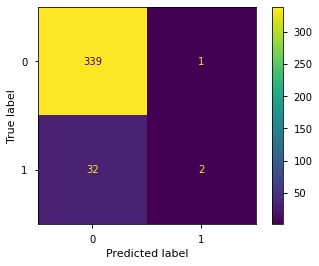

In [24]:
model_eval(baseline_lr, X_train, X_test, y_train, y_test)

These metrics indicate that we are not really underfitting or overfitting because the model is performing very poorly overall. 33 false negatives is far too many to be acceptable for our business purpose. This issue is likely caused by the fact that there are very few instances of the positive case in the training data and the type of model we trained. Before doing any additional iterations on the type or parameters of the model, let's try applying synthetic minority oversampling (SMOTE) to attempt to correct this issue.

In [25]:
# Perform SMOTE on only the training dataset
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

In [26]:
# Fit a model on the manipulated data
baseline_smote_lr = LogisticRegression(C=1e4, solver='liblinear')
baseline_smote_lr.fit(X_train_resampled, y_train_resampled)

LogisticRegression(C=10000.0, solver='liblinear')

Model Training and Test Statistics:
Test Precision: 0.12121212121212122
Train Precision: 0.6828793774319066
----------
Test Recall: 0.47058823529411764
Train Recall: 0.7048192771084337
----------
Test Accuracy: 0.6417112299465241
Train Accuracy: 0.6887550200803213
----------
Test F1: 0.1927710843373494
Train F1: 0.6936758893280632
----------
Test AUC: 0.5650086505190312
Train AUC: 0.753574035096208


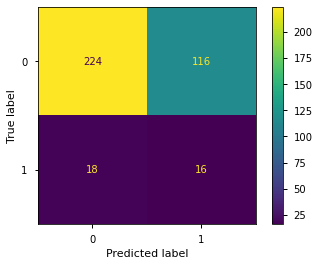

In [27]:
model_eval(baseline_smote_lr, X_train_resampled, X_test, y_train_resampled, y_test)

The new model has slightly worse recall and precision, and significantly worse accuracy. It is actually correctly identifying some positive cases now, at the cost of a proportionally large increase in false positives. Its f1 score is massively improved, and AUC is slightly improved. For the business purpose of this study, this model is performing better  - now it can actually identify true positives. However, it is far too lenient on who it approves. Let's experiment with parameters, model types, and data engineering techniques to improve it further.

First, I will experiment with a variety of different C values to see if they result in a better model.

In [28]:
C_range = [0.1, 0.5, 1, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]

for c in C_range:
    # Fit model with given C
    lr = LogisticRegression(C=c, solver='liblinear')
    model = lr.fit(X_train_resampled, y_train_resampled)
    # Print parameters of model to make it clear which model is which
    print(model)
    
    # Predict
    y_pred = model.predict(X_test)
    y_score = model.decision_function(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('AUC for current parameter:', auc(fpr, tpr))
    print('F1 for current parameter:', f1_score(y_test, y_pred))
    print('--------------------')

LogisticRegression(C=0.1, solver='liblinear')
AUC for current parameter: 0.5297145328719723
F1 for current parameter: 0.16091954022988506
--------------------
LogisticRegression(C=0.5, solver='liblinear')
AUC for current parameter: 0.5411332179930797
F1 for current parameter: 0.15568862275449102
--------------------
LogisticRegression(C=1, solver='liblinear')
AUC for current parameter: 0.5487456747404844
F1 for current parameter: 0.15384615384615383
--------------------
LogisticRegression(C=10, solver='liblinear')
AUC for current parameter: 0.5555795847750865
F1 for current parameter: 0.17177914110429449
--------------------
LogisticRegression(C=100, solver='liblinear')
AUC for current parameter: 0.5624134948096886
F1 for current parameter: 0.18292682926829268
--------------------
LogisticRegression(C=1000.0, solver='liblinear')
AUC for current parameter: 0.5652681660899654
F1 for current parameter: 0.18292682926829268
--------------------
LogisticRegression(C=10000.0, solver='liblinea

After a C paramter of 1e6, we do not seem to be getting any noticeable improvement in F1 or AUC. We also seem to be having signficant issues with overfitting of the training data. It is probably best to attempt a decision tree and random forest classifier model with the same data to see if we get better performance.

I'm going to start with a vanilla decision tree classifier first and then go from there.

## Decision Tree Classifier

These models work by splitting the data based on thresholds in the data that optimize the entropy at every step. It is possible that 

In [29]:
# Declare a random seed that we will be using for the rest of the notebook for reproducability 
SEED = 42
# Instanciate decision tree classifier class
dt_vanilla = DecisionTreeClassifier(random_state=SEED, criterion = 'entropy')

# Fitting the model with original, non-class corrected data
dt_vanilla.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

Because of an oversight I made, the model eval function I wrote earlier won't work with this type of model. I retool it below to work for decision tree and random forest models. 

In [30]:
def model_eval_tree(model, train_x, test_x, train_y, test_y):
    """
    Create predicted y values for both training and test X. Then, calculate precision, recall, accuracy, F1, fpr, tpr, and auc
    for both the training and test sets. Also create a confusion matrix and print it. Does not calculate decision function as it
    is not relevant for decision trees.
    """
    # Calculate predicted values for training and test data
    y_train_hat = model.predict(train_x)
    y_test_hat = model.predict(test_x)
    
    # Calculate evaluation statistics for test data
    test_precision = precision_score(test_y, y_test_hat)
    test_recall = recall_score(test_y, y_test_hat)
    test_accuracy = accuracy_score(test_y, y_test_hat)
    test_f1 = f1_score(test_y, y_test_hat)
    
    # Calculate evaluation statistics for training data
    train_precision = precision_score(train_y, y_train_hat)
    train_recall = recall_score(train_y, y_train_hat)
    train_accuracy = accuracy_score(train_y, y_train_hat)
    train_f1 = f1_score(train_y, y_train_hat)
    
    # ROC curve for test and training data
    fpr_test, tpr_test, thresholds_test = roc_curve(test_y, y_test_hat)
    fpr_train, tpr_train, thresholds_train = roc_curve(train_y, y_train_hat)
    
    # AUC calculations
    auc_test = auc(fpr_test, tpr_test)
    auc_train = auc(fpr_train, tpr_train)
    
    # Print confusion matrix for only test data
    cmatrix = confusion_matrix(test_y, y_test_hat)
    ConfusionMatrixDisplay(cmatrix).plot()
    
    # Print all of the evaluation statistics
    print('Model Training and Test Statistics:')
    print('Test Precision:', test_precision)
    print('Train Precision:', train_precision)
    print('----------')
    print('Test Recall:', test_recall)
    print('Train Recall:', train_recall)
    print('----------')
    print('Test Accuracy:', test_accuracy)
    print('Train Accuracy:', train_accuracy)
    print('----------')
    print('Test F1:', test_f1)
    print('Train F1:', train_f1)
    print('----------')
    print('Test AUC:', auc_test)
    print('Train AUC:', auc_train)

Model Training and Test Statistics:
Test Precision: 0.3333333333333333
Train Precision: 0.9918032786885246
----------
Test Recall: 0.38235294117647056
Train Recall: 0.9603174603174603
----------
Test Accuracy: 0.8743315508021391
Train Accuracy: 0.9946524064171123
----------
Test F1: 0.35616438356164387
Train F1: 0.9758064516129032
----------
Test AUC: 0.6529411764705882
Train AUC: 0.9796567221266017


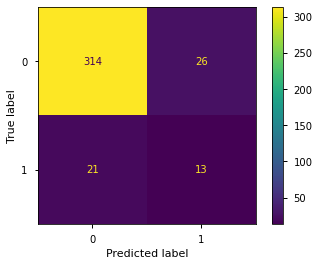

In [31]:
model_eval_tree(dt_vanilla, X_train, X_test, y_train, y_test)

Even without the class imbalance fix, this model's AUC and f1 are already better than the best logistic regression. We have increased the true positive rate without such a large increase in false positive rate. How much better will it do with the improved data?

In [32]:
dt_SMOTE = DecisionTreeClassifier(random_state=SEED, criterion = 'entropy')
dt_SMOTE.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(criterion='entropy', random_state=42)

Model Training and Test Statistics:
Test Precision: 0.2826086956521739
Train Precision: 0.9918032786885246
----------
Test Recall: 0.38235294117647056
Train Recall: 0.9603174603174603
----------
Test Accuracy: 0.8556149732620321
Train Accuracy: 0.9946524064171123
----------
Test F1: 0.325
Train F1: 0.9758064516129032
----------
Test AUC: 0.6426470588235293
Train AUC: 0.9796567221266017


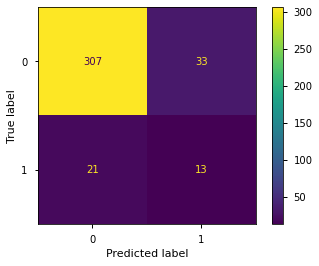

In [33]:
model_eval_tree(dt_SMOTE, X_train, X_test, y_train, y_test)

The performance with the engineered data is actually worse. The only difference is that it has one less true positive than the previous iteration. I'm going to continue using the un-smoted data and try to reduce the overfitting issue by tweaking various hyperparameters. We are going to use a grid search algorithm to find the best combination of parameters, if it is better than the vanilla parameters. I will use 3 fold cross validation to verify the result.

In [34]:
# Create the parameter grid to be tested
param_grid_DT = {
    'criterion':['entropy', 'gini'],
    'max_depth':[5, 10, 15, 20, 25, 30],
    'min_samples_split':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2],
    'min_samples_leaf':[0.1, 0.2, 0.3, 0.4, 0.5, 1]
}

In [35]:
DT_classifier = DecisionTreeClassifier()
dt_grid_search = GridSearchCV(DT_classifier, param_grid_DT, cv=3, return_train_score=True, scoring=['accuracy', 'roc_auc'], refit='roc_auc')
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5, 1],
                         'min_samples_split': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                               0.7, 0.8, 0.9, 1.0, 2]},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'roc_auc'])

In [36]:
dt_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

Here are the best parameters according to the test I performed. Let's re-create the model with these parameters and check the performance.

Model Training and Test Statistics:
Test Precision: 0.3333333333333333
Train Precision: 0.9833333333333333
----------
Test Recall: 0.38235294117647056
Train Recall: 0.9365079365079365
----------
Test Accuracy: 0.8743315508021391
Train Accuracy: 0.9910873440285205
----------
Test F1: 0.35616438356164387
Train F1: 0.9593495934959351
----------
Test AUC: 0.6529411764705882
Train AUC: 0.9672499521897112


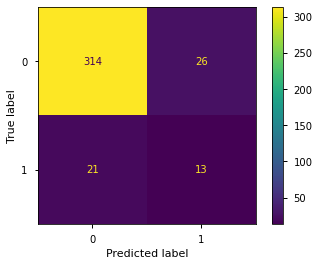

In [37]:
dt_best = DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_leaf=1)
dt_best.fit(X_train, y_train)
model_eval_tree(dt_best, X_train, X_test, y_train, y_test)

That wasn't any better than the default model's performance. What if we try and perform the same optimization with the balanced SMOTE data?

In [38]:
DT_classifier = DecisionTreeClassifier()
dt_grid_search = GridSearchCV(DT_classifier, param_grid_DT, cv=3, return_train_score=True, scoring=['accuracy', 'roc_auc'], refit='roc_auc')
dt_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5, 1],
                         'min_samples_split': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                               0.7, 0.8, 0.9, 1.0, 2]},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'roc_auc'])

In [39]:
dt_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

Model Training and Test Statistics:
Test Precision: 0.24390243902439024
Train Precision: 0.8076923076923077
----------
Test Recall: 0.29411764705882354
Train Recall: 0.6666666666666666
----------
Test Accuracy: 0.8529411764705882
Train Accuracy: 0.9447415329768271
----------
Test F1: 0.2666666666666666
Train F1: 0.7304347826086955
----------
Test AUC: 0.6014705882352942
Train AUC: 0.823293172690763


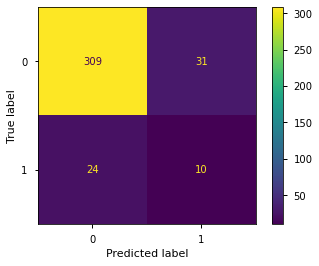

In [40]:
dt_best = DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=1)
dt_best.fit(X_train_resampled, y_train_resampled)
model_eval_tree(dt_best, X_train, X_test, y_train, y_test)

This performance also isn't better than the vanilla decision tree. Sometimes, the default parameters are the default for a reason. Now let's experiment with a random forest model and its parameters to see if the performance can be further improved.

# Random Forest Classifier

A random forest classifier is really just a bunch of decision trees trained only on random segments of the data. This means that the interpretability of these models is significantly worse than the others we've experimented with so far, but in exchange we get a type of model that tends to perform better.

In [41]:
# Fit a model with default parameters and the entropy criterion. Random state seed is necessary for this type of model.
RF = RandomForestClassifier(criterion='entropy', random_state=SEED)
RF.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [42]:
RF.score(X_test, y_test)

0.93048128342246

Model Training and Test Statistics:
Test Precision: 0.7857142857142857
Train Precision: 0.983739837398374
----------
Test Recall: 0.3235294117647059
Train Recall: 0.9603174603174603
----------
Test Accuracy: 0.93048128342246
Train Accuracy: 0.9937611408199644
----------
Test F1: 0.45833333333333326
Train F1: 0.9718875502008032
----------
Test AUC: 0.6573529411764706
Train AUC: 0.9791547140944732


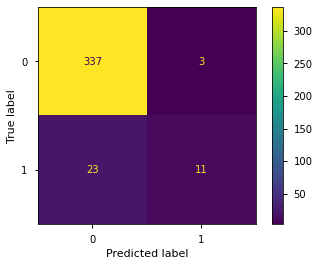

In [43]:
model_eval_tree(RF, X_train, X_test, y_train, y_test)

These results are pretty promising. The performance of this model with the vanilla parameters is the best so far. It identifies roughly the same number of true positive cases as the previous models, with an extremely low false positive rate - which is exactly what we are looking for in our specific business use case. Let's experiment with the parameters to see if we can make it even better!

In [44]:
# Fit a new model on the resampled data created in the last segment
RF_smote = RandomForestClassifier(criterion='entropy', random_state=SEED)
RF_smote.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(criterion='entropy', random_state=42)

Model Training and Test Statistics:
Test Precision: 0.631578947368421
Train Precision: 0.9761904761904762
----------
Test Recall: 0.35294117647058826
Train Recall: 0.9761904761904762
----------
Test Accuracy: 0.9224598930481284
Train Accuracy: 0.9946524064171123
----------
Test F1: 0.45283018867924524
Train F1: 0.9761904761904762
----------
Test AUC: 0.6661764705882353
Train AUC: 0.9865892139988526


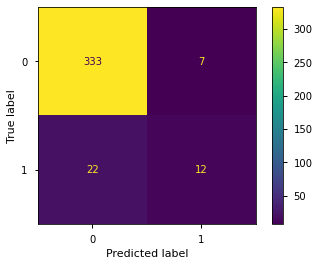

In [45]:
model_eval_tree(RF_smote, X_train, X_test, y_train, y_test)

In [46]:
# Declare the parameters that make up the testing grid
param_grid_RF = {
    'criterion':['entropy', 'gini'],
    'max_depth':[None, 10, 15, 20, 30],
    'n_estimators':[10, 30, 100, 200]
}

In [47]:
# Search every combination of parameters in the grid with a cross-fold validation value of 3 for the optimal result
RF_search = RandomForestClassifier(random_state=SEED)
RF_grid_search = GridSearchCV(RF_search, param_grid_RF, cv=3, return_train_score=True, scoring=['accuracy', 'roc_auc'], refit='roc_auc')
RF_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 10, 15, 20, 30],
                         'n_estimators': [10, 30, 100, 200]},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'roc_auc'])

In [48]:
RF_grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 30}

Model Training and Test Statistics:
Test Precision: 0.7333333333333333
Train Precision: 0.975609756097561
----------
Test Recall: 0.3235294117647059
Train Recall: 0.9523809523809523
----------
Test Accuracy: 0.9278074866310161
Train Accuracy: 0.9919786096256684
----------
Test F1: 0.4489795918367347
Train F1: 0.963855421686747
----------
Test AUC: 0.6558823529411765
Train AUC: 0.9746844520940906


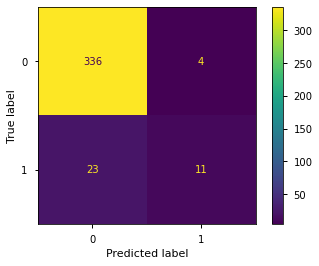

In [49]:
model_eval_tree(RF_grid_search.best_estimator_, X_train, X_test, y_train, y_test)

The best outcome of this grid search was worse than the vanilla parameters, but this is likely due to the random state of the random forest classifier. If I had used a different seed, it may have produced a better model. Either way, it isn't that much worse - it identified the same number of true positives, and only added one additional false positive.

We have determined that the random forest model is the best type of model for this problem, and a set of parameters that result in the best training outcome. We could stop here and call it good (the performance of this model is by no means perfect, but it is well specialized to the specific task it was trained for), but I can think of one way I might improve it. Let's experiment with different imbalanced resamplings of the training data.

# SMOTE Experimentation

By default, SMOTE makes both labels occur in the data with equal frequency. What if we tweak this to increase the frequency of positive labels in the data without making it 1:1? Would this increase the true positive identification rate without costing us too many false positives?

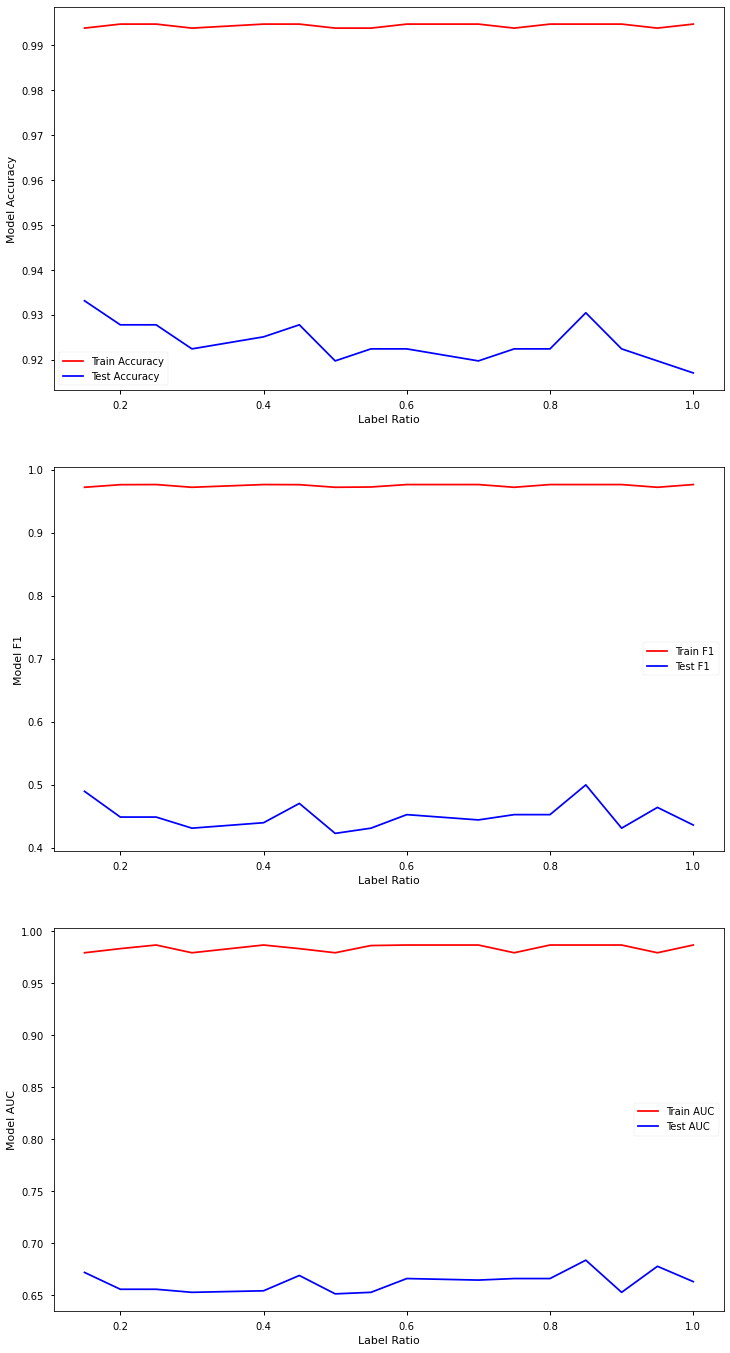

In [50]:
# Declare a list of ratios to test
ratios = [0.15, 0.2, 0.25, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

# Create empty lists that results will be appended to
train_accuracy = []
train_f1 = []
train_auc = []

test_accuracy = []
test_f1 = []
test_auc = []

for ratio in ratios:
    # Resample the data with the given ratio
    X_train_resampled, y_train_resampled = SMOTE(sampling_strategy=ratio, random_state=SEED).fit_resample(X_train, y_train)
    # Fit a new model with the default parameters and the new resampled data
    random_forest = RandomForestClassifier(criterion='entropy', random_state=SEED)
    random_forest.fit(X_train_resampled, y_train_resampled)
    
    # Calculate evaluation statistics and append them to the lists created outside of the loop so that they can be graphed
    test_pred = random_forest.predict(X_test)
    train_pred = random_forest.predict(X_train)
    
    test_acc = accuracy_score(y_test, test_pred)
    test_accuracy.append(test_acc)
    train_acc = accuracy_score(y_train, train_pred)
    train_accuracy.append(train_acc)
    
    f1te = f1_score(y_test, test_pred)
    test_f1.append(f1te)
    f1tr = f1_score(y_train, train_pred)
    train_f1.append(f1tr)
    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_pred)
    test_auc.append(auc(fpr_test, tpr_test))
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, train_pred)
    train_auc.append(auc(fpr_train, tpr_train))
    
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(12,24))

ax1.plot(ratios, train_accuracy, color='r', label='Train Accuracy')
ax1.plot(ratios, test_accuracy, color='b', label='Test Accuracy')
ax1.set_xlabel('Label Ratio')
ax1.set_ylabel('Model Accuracy')
ax1.legend()

ax2.plot(ratios, train_f1, color='r', label='Train F1')
ax2.plot(ratios, test_f1, color='b', label='Test F1')
ax2.set_xlabel('Label Ratio')
ax2.set_ylabel('Model F1')
ax2.legend()

ax3.plot(ratios, train_auc, color='r', label='Train AUC')
ax3.plot(ratios, test_auc, color='b', label='Test AUC')
ax3.set_xlabel('Label Ratio')
ax3.set_ylabel('Model AUC')
ax3.legend()

There seems to be a slight peak in the evaluation statistics I chose at a ratio of 0.85. Let's try resampling the data at this ratio and training a model so we can compare it to the default parameters.

In [51]:
X_train_085, y_train_085 = SMOTE(sampling_strategy=0.85).fit_resample(X_train, y_train)

Model Training and Test Statistics:
Test Precision: 0.5714285714285714
Train Precision: 0.968503937007874
----------
Test Recall: 0.35294117647058826
Train Recall: 0.9761904761904762
----------
Test Accuracy: 0.9171122994652406
Train Accuracy: 0.9937611408199644
----------
Test F1: 0.43636363636363634
Train F1: 0.9723320158102767
----------
Test AUC: 0.6632352941176471
Train AUC: 0.986087205966724


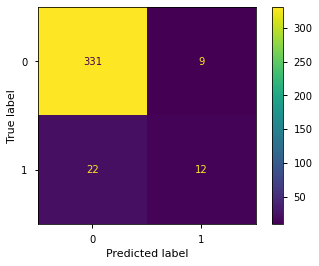

In [52]:
random_forest085 = RandomForestClassifier(criterion='gini', max_depth=20, n_estimators=200)
random_forest085.fit(X_train_085, y_train_085)
model_eval_tree(random_forest085, X_train, X_test, y_train, y_test)

The outcome of this experimentation is a model that is still slightly worse than the vanilla random forest classifier. It doubled the number of false positives for only a very small increase in the number of true positives, which is not really worth it for our use case. This analysis did not yeild a significant increase in model performance, so the default parameters and regular data created the model we will use for the rest of the analysis.

# Model Analysis

The best model is a random forest classifier, which makes the task of interpretation quite difficult. The parameters chosen for this model mean that it has 200 individual decision trees that compose it, each contributing to the output of the model. Our best bet to analyze the model is to create a plot of feature importances, or estimated values of how important each feature is to the model. Based on these feature importances, we can make inference about which features banks consider the most important when deciding whether to approve or deny credit card applications.

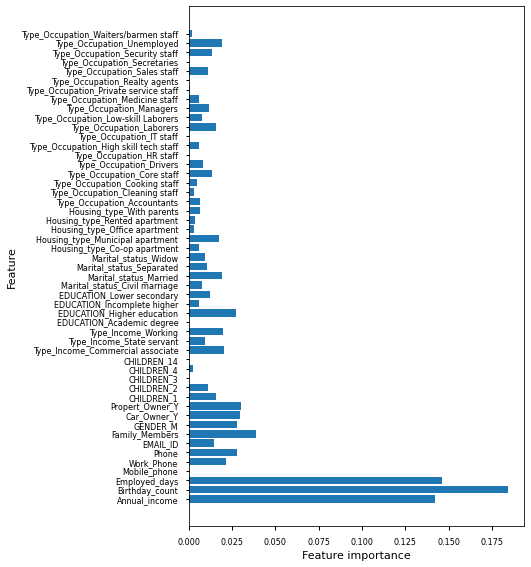

In [53]:
# Create a function that plots feature importances of a model.
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.tick_params(labelsize=8)

plot_feature_importances(RF)

This chart reports that the birthday count (age of applicant), days employed at current job, and anual income are the most important factors in deciding whether or not to grant a credit card to applicants. 

These features allow us to build a profile for the type of person that is frequently approved for credit cards. They are likely in their mid to late twenties - the older they are, the better they are for the bank. The ideal applicant has a steady annual income and has been in their current job for over a year. Having more than two family members is also strongly correlated with the approval of the application.

The best recommendation we can get out of our random forest model is which features are the most important to it. However, it is difficult to translate these most important features into actionable advice. To perform this translation, we will create a decision tree with just these most important features to attempt to create reasonable thresholds for rejection or approval based on these features. We want to prioritize interpretability, so we will set a maximum depth of 5.

In [54]:
X_test = X_test[['Annual_income', 'Birthday_count', 'Employed_days']]
X_train = X_train[['Annual_income', 'Birthday_count', 'Employed_days']]

In [59]:
best_features = DecisionTreeClassifier(random_state=SEED, criterion = 'entropy', max_depth=5)
best_features.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

Model Training and Test Statistics:
Test Precision: 0.2222222222222222
Train Precision: 0.6444444444444445
----------
Test Recall: 0.058823529411764705
Train Recall: 0.23015873015873015
----------
Test Accuracy: 0.8957219251336899
Train Accuracy: 0.8992869875222816
----------
Test F1: 0.09302325581395347
Train F1: 0.3391812865497076
----------
Test AUC: 0.5191176470588236
Train AUC: 0.6070472365653089


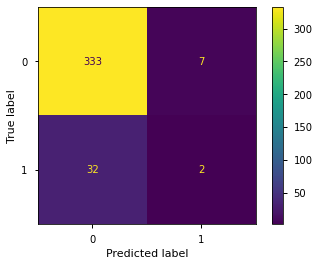

In [60]:
model_eval_tree(best_features, X_train, X_test, y_train, y_test)

Funny enough, this model actually performs better than the original vanilla decision tree classifier. Because it only deals with three features this tree should be pretty simple, so let's plot it.

[Text(2291.785714285714, 4983.0, 'Employed_days <= 0.035\nentropy = 0.507\nsamples = 1122\nvalue = [996, 126]'),
 Text(398.57142857142856, 4077.0, 'Birthday_count <= 0.27\nentropy = 0.373\nsamples = 598\nvalue = [555, 43]'),
 Text(199.28571428571428, 3171.0, 'entropy = 0.0\nsamples = 57\nvalue = [57, 0]'),
 Text(597.8571428571429, 3171.0, 'Birthday_count <= 0.272\nentropy = 0.4\nsamples = 541\nvalue = [498, 43]'),
 Text(398.57142857142856, 2265.0, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(797.1428571428571, 2265.0, 'Annual_income <= 0.146\nentropy = 0.394\nsamples = 540\nvalue = [498, 42]'),
 Text(398.57142857142856, 1359.0, 'Annual_income <= 0.143\nentropy = 0.435\nsamples = 425\nvalue = [387, 38]'),
 Text(199.28571428571428, 453.0, 'entropy = 0.42\nsamples = 423\nvalue = [387, 36]'),
 Text(597.8571428571429, 453.0, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(1195.7142857142858, 1359.0, 'Birthday_count <= 0.517\nentropy = 0.218\nsamples = 115\nvalue = [111, 4]'),
 

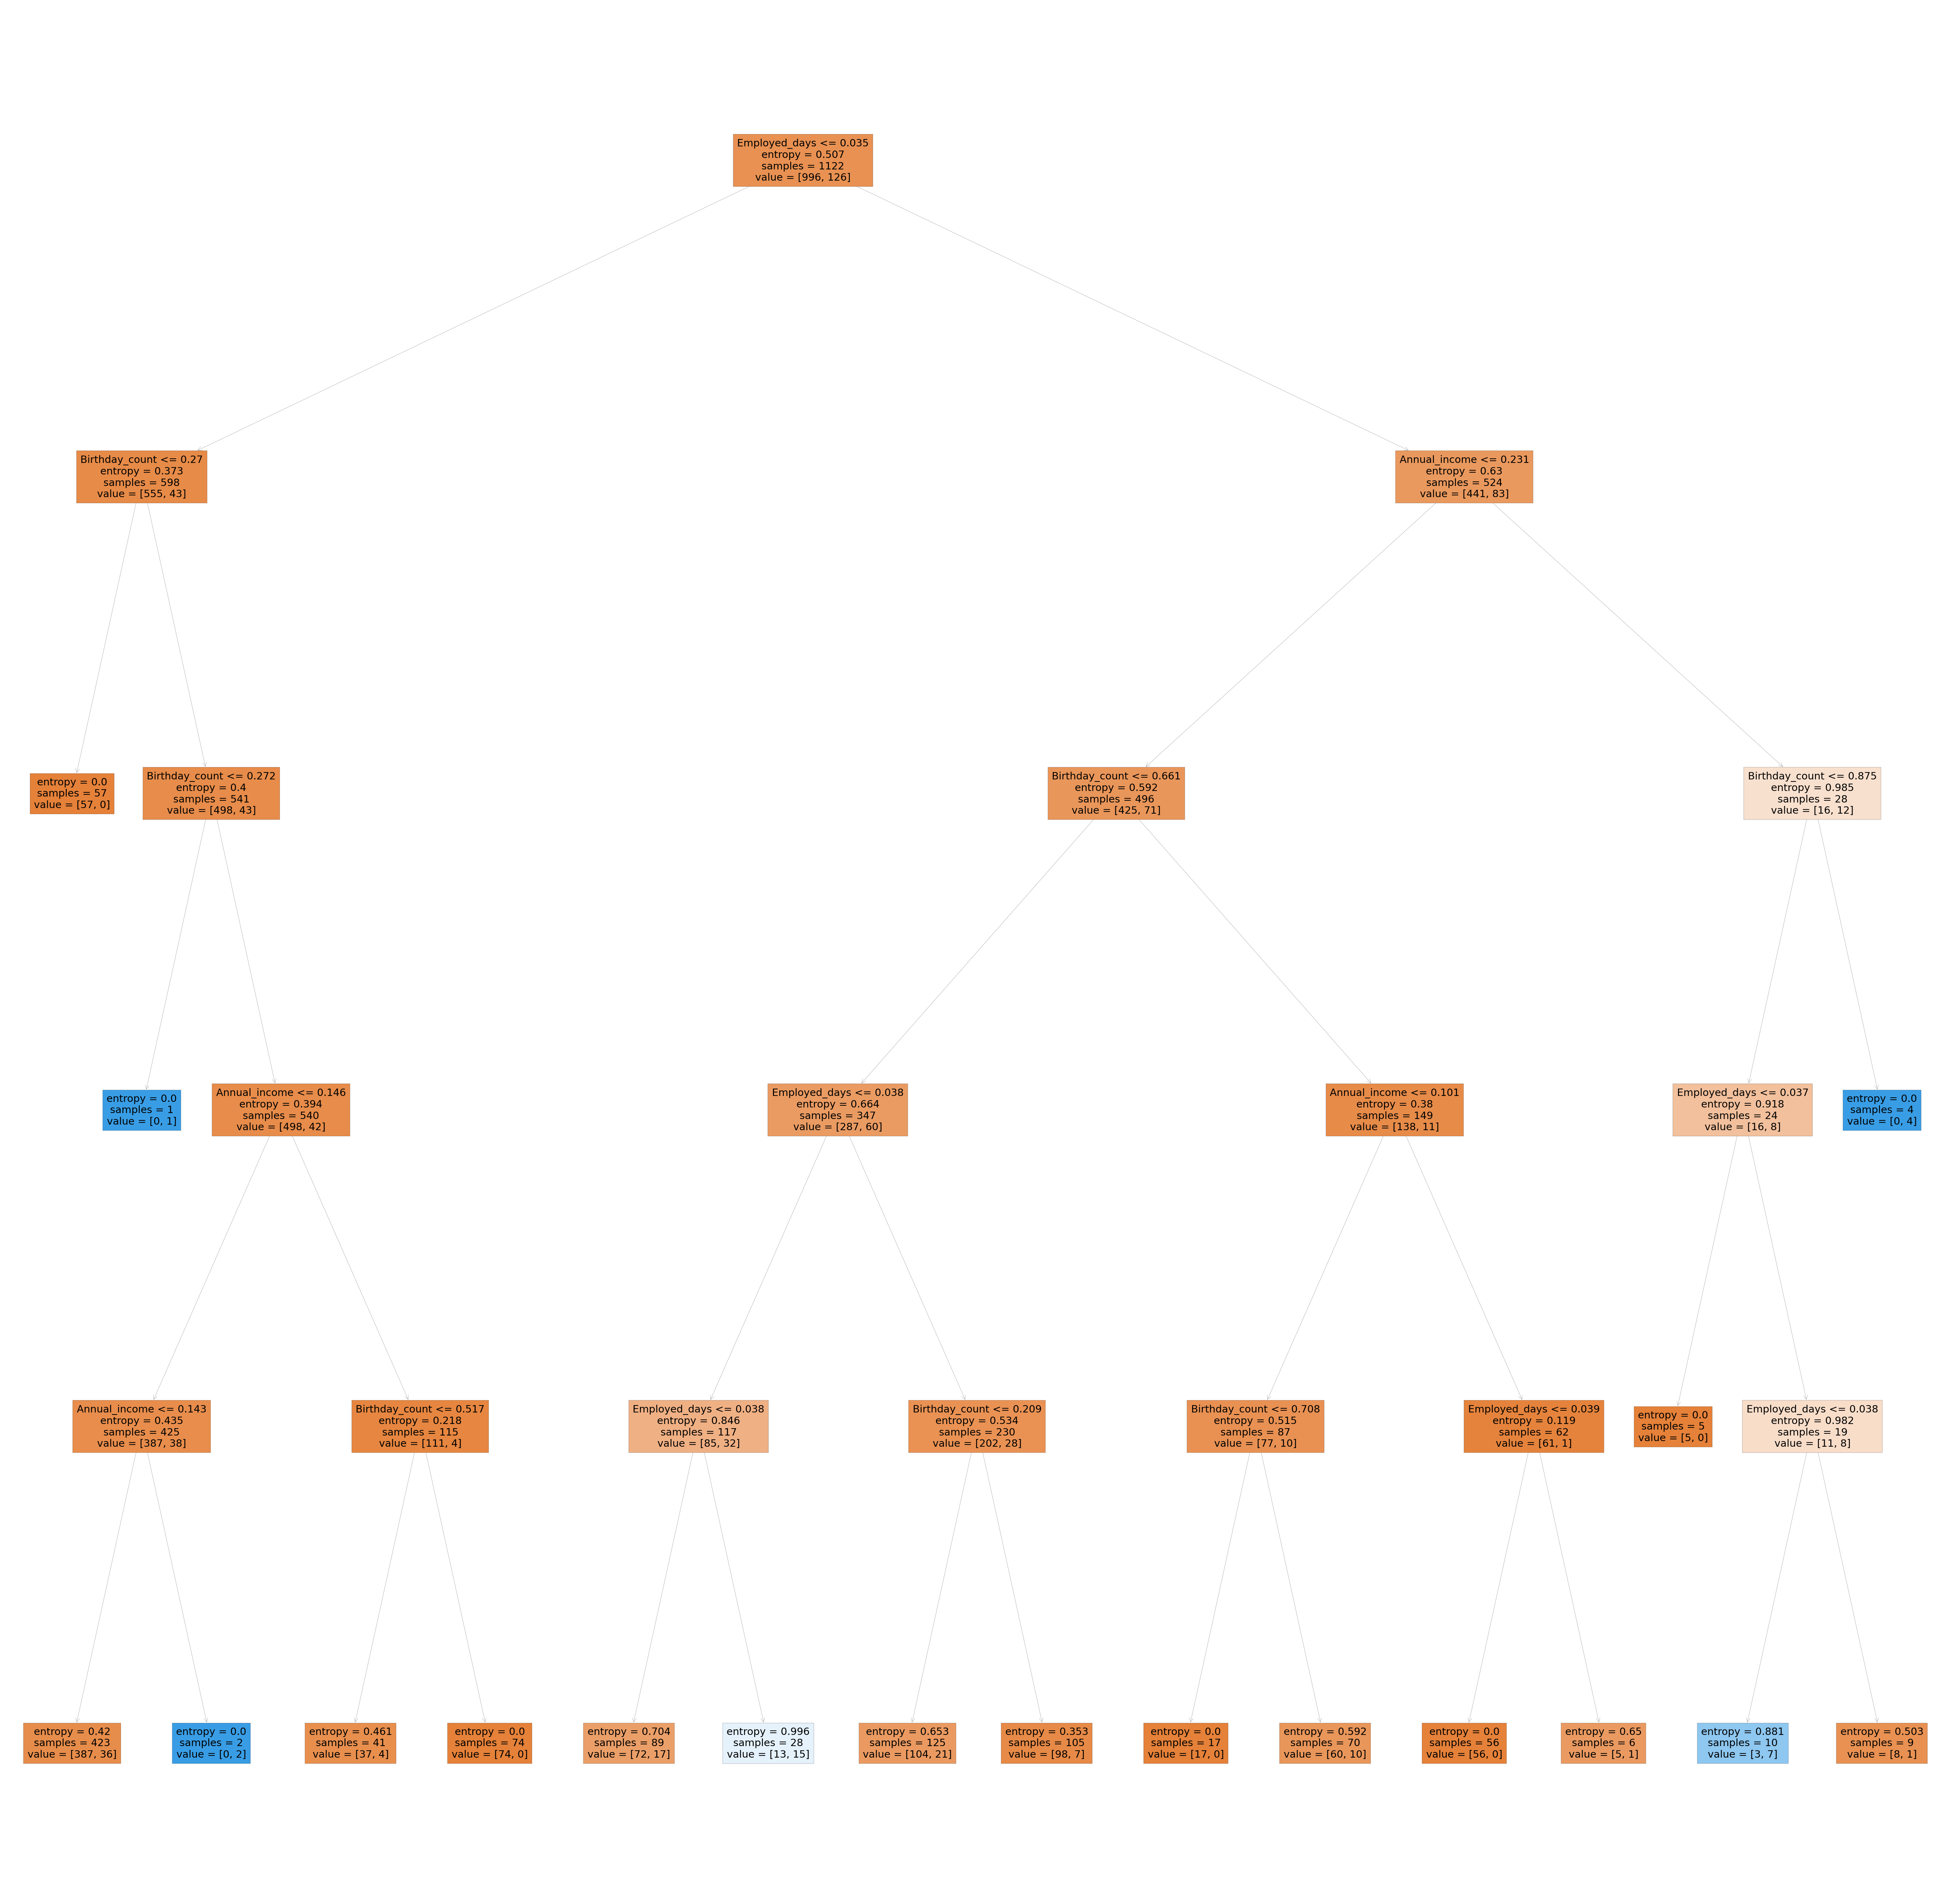

In [61]:
plt.figure(figsize=(100,100))
plot_tree(best_features, feature_names=X_test.columns, filled=True)

In [62]:
text_representation = export_text(best_features)
print(text_representation)

|--- feature_2 <= 0.04
|   |--- feature_1 <= 0.27
|   |   |--- class: 0
|   |--- feature_1 >  0.27
|   |   |--- feature_1 <= 0.27
|   |   |   |--- class: 1
|   |   |--- feature_1 >  0.27
|   |   |   |--- feature_0 <= 0.15
|   |   |   |   |--- feature_0 <= 0.14
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_0 >  0.14
|   |   |   |   |   |--- class: 1
|   |   |   |--- feature_0 >  0.15
|   |   |   |   |--- feature_1 <= 0.52
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_1 >  0.52
|   |   |   |   |   |--- class: 0
|--- feature_2 >  0.04
|   |--- feature_0 <= 0.23
|   |   |--- feature_1 <= 0.66
|   |   |   |--- feature_2 <= 0.04
|   |   |   |   |--- feature_2 <= 0.04
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_2 >  0.04
|   |   |   |   |   |--- class: 1
|   |   |   |--- feature_2 >  0.04
|   |   |   |   |--- feature_1 <= 0.21
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_1 >  0.21
|   |   |   |   |   |--- class: 0
|   |   

days employed less than 4% of maximum and birthday count less than 27% of max = reject



In [ ]:
X.columns